# Analysis of the Covid-19 global dataset using Spark

# I - Configuration of the Spark Session

In [1]:
import findspark
findspark.init()
import pyspark

## Imports

In [2]:
#useful pyspark imports
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import * 
from pyspark.sql import SparkSession,SQLContext,Window
from pyspark import StorageLevel

#importing python libraries 
from IPython.display import Markdown, display
import datetime
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as plg

# useful imports for the queries
from shapely.geometry import Point, Polygon
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,OneHotEncoder, StringIndexer
import numpy as np

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PROJ_LIB'] = r'C:\\Users\\EngrS\anaconda3\pkgs\proj-6.2.1-h9f7ef89_0\Library\share'
from mpl_toolkits.basemap import Basemap
from matplotlib.cbook import dedent

#imports for measure processing time
import time

In [3]:
start2 = time.time()

## Build PySpark Session

In [4]:
"""
#Custom configuration for analyzing the various driver-executor combinations and 
processig time on a stand alone system 
driver_number_cores = 7
driver_memory_gb = 14
executor_number_cores = 7
executor_memory_gb = 14
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(driver_number_cores))\
        .set('spark.driver.memory', '{}g'.format(driver_memory_gb)\
        .set('spark.executor.cores', '{}'.format(executor_number_cores)\
        .set('spark.executor.memory', '{}g'.format(executor_memory_gb)
        ))"""

sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()

In [5]:
spark.sparkContext._conf.getAll()

[('spark.driver.host', 'LAPTOP-0ED48IAC.mshome.net'),
 ('spark.driver.port', '52746'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1610329925900'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

# II - Data understanding

In [6]:
df = spark.read.options(header='True', inferSchema='True', delimiter=',')\
          .csv("time_series_covid19_confirmed_global.csv")

df.select("Province/State","Country/Region","Lat","Long","1/22/20","1/23/20")\
  .show(10)

+--------------------+-------------------+--------+---------+-------+-------+
|      Province/State|     Country/Region|     Lat|     Long|1/22/20|1/23/20|
+--------------------+-------------------+--------+---------+-------+-------+
|                null|        Afghanistan|33.93911|67.709953|      0|      0|
|                null|            Albania| 41.1533|  20.1683|      0|      0|
|                null|            Algeria| 28.0339|   1.6596|      0|      0|
|                null|            Andorra| 42.5063|   1.5218|      0|      0|
|                null|             Angola|-11.2027|  17.8739|      0|      0|
|                null|Antigua and Barbuda| 17.0608| -61.7964|      0|      0|
|                null|          Argentina|-38.4161| -63.6167|      0|      0|
|                null|            Armenia| 40.0691|  45.0382|      0|      0|
|Australian Capita...|          Australia|-35.4735| 149.0124|      0|      0|
|     New South Wales|          Australia|-33.8688| 151.2093|   

In [7]:
#Printinf dataset starting and end date
start_date = df.schema.names[4]
end_date = df.schema.names[-1]

def print_markdown(string):
    display(Markdown(string))
    
print_markdown(f'### ******** The dataset is from Date(mm/dd/yy) \
               {start_date} upto {end_date} *********')

### ******** The dataset is from Date(mm/dd/yy)                1/22/20 upto 1/6/21 *********

In [8]:
df.filter(col("Country/Region").isin(['Australia']))\
  .select("Province/State","Country/Region","Lat",
          "Long","1/22/20","1/23/20").show()

+--------------------+--------------+--------+--------+-------+-------+
|      Province/State|Country/Region|     Lat|    Long|1/22/20|1/23/20|
+--------------------+--------------+--------+--------+-------+-------+
|Australian Capita...|     Australia|-35.4735|149.0124|      0|      0|
|     New South Wales|     Australia|-33.8688|151.2093|      0|      0|
|  Northern Territory|     Australia|-12.4634|130.8456|      0|      0|
|          Queensland|     Australia|-27.4698|153.0251|      0|      0|
|     South Australia|     Australia|-34.9285|138.6007|      0|      0|
|            Tasmania|     Australia|-42.8821|147.3272|      0|      0|
|            Victoria|     Australia|-37.8136|144.9631|      0|      0|
|   Western Australia|     Australia|-31.9505|115.8605|      0|      0|
+--------------------+--------------+--------+--------+-------+-------+



In [9]:
df.filter(col("Province/State")!='null')\
  .groupBy("Country/Region")\
  .agg(count("Province/State").alias("Number of Province/States"))\
  .show()

+--------------+-------------------------+
|Country/Region|Number of Province/States|
+--------------+-------------------------+
|        France|                       11|
|         China|                       33|
|       Denmark|                        2|
|        Canada|                       16|
|     Australia|                        8|
|United Kingdom|                       10|
|   Netherlands|                        4|
+--------------+-------------------------+



## Inconsistencies in the dataset

### Cases cumulated inconsistency

In [10]:
df.select("Country/Region","5/4/20","5/5/20","5/6/20","5/7/20",
          "5/8/20","5/9/20","5/10/20",
         "5/11/20","5/12/20","5/13/20","5/14/20")\
  .where(col("Country/Region")=='Ecuador').show()

+--------------+------+------+------+------+------+------+-------+-------+-------+-------+-------+
|Country/Region|5/4/20|5/5/20|5/6/20|5/7/20|5/8/20|5/9/20|5/10/20|5/11/20|5/12/20|5/13/20|5/14/20|
+--------------+------+------+------+------+------+------+-------+-------+-------+-------+-------+
|       Ecuador| 31881| 31881| 31881| 30298| 28818| 29071|  29559|  29509|  30419|  30486|  30502|
+--------------+------+------+------+------+------+------+-------+-------+-------+-------+-------+



### Ships inconsistency

In [11]:
#filtering columns with no latitude and longitude
df.where(col("Lat").isNull() | col("Long").isNull())\
  .select("Country/Region","Province/State","Lat","Long").show()

+--------------+--------------------+----+----+
|Country/Region|      Province/State| Lat|Long|
+--------------+--------------------+----+----+
|        Canada|Repatriated Trave...|null|null|
+--------------+--------------------+----+----+



In [12]:
#Filling  null with 0.0 double 
df = df.fillna(0.0, subset=["Lat","Long"])
df.where(col("Lat").isNull() | col("Long").isNull())\
  .select("Country/Region","Province/State","Lat","Long").show()

+--------------+--------------+---+----+
|Country/Region|Province/State|Lat|Long|
+--------------+--------------+---+----+
+--------------+--------------+---+----+



In [13]:
df.where((col("Lat") == 0)|(col("Long") == 0))\
  .select("Province/State","Country/Region","Lat","Long","1/22/20").show()

+--------------------+----------------+---+----+-------+
|      Province/State|  Country/Region|Lat|Long|1/22/20|
+--------------------+----------------+---+----+-------+
|    Diamond Princess|          Canada|0.0| 0.0|      0|
|      Grand Princess|          Canada|0.0| 0.0|      0|
|Repatriated Trave...|          Canada|0.0| 0.0|      0|
|                null|Diamond Princess|0.0| 0.0|      0|
|                null|      MS Zaandam|0.0| 0.0|      0|
+--------------------+----------------+---+----+-------+



# III - Preprocessing Data

In [14]:
start = time.time()

## III.1 Transpose the dataframe

In [15]:
old_pivotdf = df.select("Province/State","Country/Region",
                        "Lat","Long",
                        lit('1/22/20').alias("Date"),
                        col("1/22/20").alias("CasesCum"))
i=1
while i<len(df.columns[4:]):
    new_pivotdf = df.select("Province/State", "Country/Region",
                            "Lat", "Long",
                            lit(df.columns[4+i]).alias("Date"),
                            col(df.columns[4+i]).alias("CasesCum"))
                       
    old_pivotdf = old_pivotdf.unionAll(new_pivotdf)
    i=i+1
    
old_pivotdf.show()

+--------------------+-------------------+---------+----------+-------+--------+
|      Province/State|     Country/Region|      Lat|      Long|   Date|CasesCum|
+--------------------+-------------------+---------+----------+-------+--------+
|                null|        Afghanistan| 33.93911| 67.709953|1/22/20|       0|
|                null|            Albania|  41.1533|   20.1683|1/22/20|       0|
|                null|            Algeria|  28.0339|    1.6596|1/22/20|       0|
|                null|            Andorra|  42.5063|    1.5218|1/22/20|       0|
|                null|             Angola| -11.2027|   17.8739|1/22/20|       0|
|                null|Antigua and Barbuda|  17.0608|  -61.7964|1/22/20|       0|
|                null|          Argentina| -38.4161|  -63.6167|1/22/20|       0|
|                null|            Armenia|  40.0691|   45.0382|1/22/20|       0|
|Australian Capita...|          Australia| -35.4735|  149.0124|1/22/20|       0|
|     New South Wales|      

# III.2 Sort the inconsistencies

### Sort the cumulated cases inconsistency

In [16]:
#The function date from string type to date type for better handeling
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
DF = old_pivotdf.withColumn("Date",F.to_date(F.col("Date"),"MM/dd/yy"))
DF = DF.na.fill("null")

In [17]:
def cases_inconsistencies(casescum,country,state):     
    """
    Return the column CasesCum in which the inconsistencies related
    to the nb of cases have been sorted out. It will be used as an UDF 
    function.
    
    Parameters:
    casescum (Array) : values in column CasesCum (number 
                       of positive cases cumulated) with inconsistencies.
    country (Array) : values in column Country/Region. 
    state (Array) : values in column Province/State.
    
    Return 
    casescum (Array) : values in column CasesCum (number of positive 
                       cases cumulated) without any inconsistency.
    """
    for i in range(1,len(casescum)):
        if  country[i]==country[i-1] and state[i]==state[i-1]:
                if casescum[i]<casescum[i-1]:
                    casescum[i]=casescum[i-1]       
    return casescum

udf_cases_inconsistencies = F.udf(cases_inconsistencies,ArrayType(IntegerType()))

In [18]:
New_DF = DF.orderBy("Country/Region","Province/State","Date") \
            .agg(F.collect_list("Province/State").alias("Province/State"),
                 F.collect_list("Country/Region").alias("Country/Region"),
                 F.collect_list("CasesCum").alias("CasesCum"),
                 F.collect_list("Lat").alias("Latitude"),
                 F.collect_list("Long").alias("Longitude"),
                 F.collect_list("Date").alias("Date"))\
             .withColumn("CasesCum", 
                    udf_cases_inconsistencies(col("CasesCum"),
                                            col("Country/Region"),
                                            col("Province/State")))\
             .withColumn("zipped", 
                        F.explode(F.arrays_zip("Province/State",
                                     "Country/Region",
                                     "Latitude","Longitude",
                                     "Date",
                                     "CasesCum")))\
             .select("zipped.*")

### Remove the ships inconsistency 

In [19]:
#dropping columns with zero lat long values
New_DF = New_DF.filter((col("Latitude")  != 0.0 ) & (col("Longitude") != 0.0) )

## III.3 Create Additional columns

### Column Cases

In [20]:
window = Window.partitionBy("Country/Region","Province/State") \
               .orderBy(col("Country/Region").asc())\
               .orderBy(col("Province/State").asc()) \
               .orderBy("Date")

New_DF = New_DF.withColumn("prev_value", 
                           F.lag(New_DF.CasesCum).over(window))

In [21]:
New_DF = New_DF.withColumn('Cases',
                  F.when(F.col("prev_value").isNull(),
                       F.col("CasesCum"))
               .otherwise(F.col("CasesCum")-F.col("prev_value")))\
               .drop("prev_value")\
               .orderBy("Country/Region","Province/State","Date")

### Column Days Elapsed

In [22]:
dt = datetime.datetime.strptime(df.schema.names[4], '%m/%d/%y').date()
New_DF = New_DF.withColumn("Days Elapsed", datediff((to_date("Date")),(to_date(lit(str(dt))))))

### Columns Day, Month and Year

In [23]:
split_col = split(New_DF['Date'],'-')
New_DF = New_DF.withColumn('Day',split_col.getItem(2).cast(IntegerType()))
New_DF = New_DF.withColumn('Month',split_col.getItem(1).cast(IntegerType()))
New_DF = New_DF.withColumn('Year',split_col.getItem(0).cast(IntegerType()))


New_DF = New_DF.select("Province/State","Country/Region","Latitude","Longitude",
                       "Date","Day","Month", "Year","Days Elapsed","Cases")

### Columns Continent (based on Longitude and Latitude) and Week

In [24]:
def latlong_to_continent(longitude,latitude):
    '''
    Return the continent to which the country or state belongs to given its latitude
    and its longitude.
    
    Parameters:
    longitude (float): value of the longitude of the country or state.
    latitude (float): value of the latitude of the country or state.
    
    Returns:
    continent (string): continent to which the country or state belongs to.
    '''
          
    p1 = Point(longitude,latitude)
    
    #Define the polygon
    
    cord_euorope = [(-10,90),(77.5,90),(48.8,42.5),(30,42.5),(28.81,40.79),
                    (29,41),(27.31,40.55),(26.75,40.40),(26.36,40.05),(25.19,39.17),
                    (27.91,35.46),(27.5,33),(10,38),(-10,35.42),(-13,28.25),(-30,15),
                    (-37.5,57.5),(-10,78.13)]
    europe = Polygon(cord_euorope)
    
    cord_asia1 = [(77.5,90),(48.8,42.5),(30,42.5),(28.81,40.79),(29,41),(27.31,40.55),
                  (26.75,40.4),(26.36,40.05),(25.19,39.17),(35.46,27.91),(27.5,33),
                  (34.58,31.74),(34.92,29.54),(34.46,27.78),(44.3,11.3),(52,12.5),(75,-60),
                  (110,-60),(110,-31.88),(110,-11.88),(140,-10.27),(140,33.13),(166.6,51),
                  (180,60),(180,90)]
    asia1 = Polygon(cord_asia1)
    
    cord_asia2 = [(-180,90),(-168.75,90),(-168.75,60),(-180,60)]
    asia2 = Polygon(cord_asia2)
    
    cord_Oceania = [(110,-11.88),(130,-8),(127.5,0),(150,5),(180,0),(180,-62),
                    (140,-62),(110,-31.88)]
    Oceania = Polygon(cord_Oceania)
    
    cord_america = [(-168.75,90),(-10,90),(-10,78.3),(-37.5,57.5),(-30,15),(-30,-60),
                    (-105,-60),(-105,1.25),(-180,51),(-180,60),(-168.75,60),(-168.75,60)]
    america = Polygon(cord_america)
    
    cord_africa = [(-30,15),(-13,28.25),(-10,35.42),(10,38),(27.5,38.33),(34.58,31.74),
                   (34.92,29.54),(34.46,27.78),(44.3,11.3),(52,12.5),(75,-60),(-30,-60)]
    africa = Polygon(cord_africa)
    
    cord_antarctica = [(-180,-60),(180,-60),(180,-90),(-180,-90)]
    antarctica = Polygon(cord_antarctica)
    
    # check in which continent it belongs to
    if p1.within(europe):
        continent = "Europe"
    elif p1.within(asia1) or p1.within(asia2):
         continent = "Asia"
    elif p1.within(Oceania):
        continent = "Oceania"
    elif p1.within(america):
        continent = "America"
    elif p1.within(africa):
        continent = "Africa"
    elif p1.within(antarctica):
        continent = "Antarctica"
    else:
        continent = "Unidentified"

    return continent

udf_latlong_to_continent = F.udf(latlong_to_continent,StringType())

### Column Week

In [25]:
df_preprocessed = New_DF.withColumn('Continent',
                                   udf_latlong_to_continent(col("Longitude"),col("Latitude")))\
                        .withColumn("Week",weekofyear(col("Date")))

In [26]:
df_preprocessed = df_preprocessed.select("Continent","Province/State","Country/Region",
                                         "Latitude","Longitude",
                                         "Date","Month","Day","Year","Week",
                                        "Days Elapsed","Cases")

In [27]:
end = time.time()
print(end - start)

55.90293312072754


### Form of the final dataframe

In [28]:
df_preprocessed_persisted = df_preprocessed.persist(StorageLevel.MEMORY_AND_DISK)

In [29]:
df_preprocessed_persisted.show()

+---------+--------------+--------------+--------+---------+----------+-----+---+----+----+------------+-----+
|Continent|Province/State|Country/Region|Latitude|Longitude|      Date|Month|Day|Year|Week|Days Elapsed|Cases|
+---------+--------------+--------------+--------+---------+----------+-----+---+----+----+------------+-----+
|     Asia|          null|   Afghanistan|33.93911|67.709953|2020-01-22|    1| 22|2020|   4|           0|    0|
|     Asia|          null|   Afghanistan|33.93911|67.709953|2020-01-23|    1| 23|2020|   4|           1|    0|
|     Asia|          null|   Afghanistan|33.93911|67.709953|2020-01-24|    1| 24|2020|   4|           2|    0|
|     Asia|          null|   Afghanistan|33.93911|67.709953|2020-01-25|    1| 25|2020|   4|           3|    0|
|     Asia|          null|   Afghanistan|33.93911|67.709953|2020-01-26|    1| 26|2020|   4|           4|    0|
|     Asia|          null|   Afghanistan|33.93911|67.709953|2020-01-27|    1| 27|2020|   5|           5|    0|
|

# IV - Implementation and results

# Query 1

In [30]:
start = time.time()

In [31]:
df_query1 = df_preprocessed_persisted.select("Province/State","Country/Region",
                                   "Day","Month", "Year","Cases")

In [32]:
df_query1_persist = df_query1.persist(StorageLevel.MEMORY_AND_DISK)

In [33]:
query1 = df_query1_persist.groupBy("Country/Region","Month","Year","Day")\
                          .agg(sum("Cases").alias("Daily_Sum"))\
                          .groupBy("Country/Region","Year","Month")\
                          .agg(round(avg("Daily_Sum"),0).alias("Daily_Cases"))\
                          .sort(asc("Country/Region"),asc("Year"),asc("Month"))

query1.show()

+--------------+----+-----+-----------+
|Country/Region|Year|Month|Daily_Cases|
+--------------+----+-----+-----------+
|   Afghanistan|2020|    1|        0.0|
|   Afghanistan|2020|    2|        0.0|
|   Afghanistan|2020|    3|        6.0|
|   Afghanistan|2020|    4|       65.0|
|   Afghanistan|2020|    5|      422.0|
|   Afghanistan|2020|    6|      543.0|
|   Afghanistan|2020|    7|      166.0|
|   Afghanistan|2020|    8|       48.0|
|   Afghanistan|2020|    9|       37.0|
|   Afghanistan|2020|   10|       70.0|
|   Afghanistan|2020|   11|      162.0|
|   Afghanistan|2020|   12|      169.0|
|   Afghanistan|2021|    1|      263.0|
|       Albania|2020|    1|        0.0|
|       Albania|2020|    2|        0.0|
|       Albania|2020|    3|        8.0|
|       Albania|2020|    4|       18.0|
|       Albania|2020|    5|       12.0|
|       Albania|2020|    6|       47.0|
|       Albania|2020|    7|       88.0|
+--------------+----+-----+-----------+
only showing top 20 rows



In [34]:
end = time.time()
print(end - start)

189.49628472328186


In [35]:
"""
# To save the output of query 1 as a csv 

query1_result_persisted .repartition(1).write.format("com.databricks.spark.csv").option("header", "true").mode('overwrite')\
   .save("query1_result")"""

'\n# To save the output of query 1 as a csv \n\nquery1_result_persisted .repartition(1).write.format("com.databricks.spark.csv").option("header", "true").mode(\'overwrite\')   .save("query1_result")'

In [36]:
def plot_graphs_query_1(query1_dataframe, country):
    '''
    Plots the bar chart of the average number of daily new cases
    for each month for the chosen country.
    
    Parameters:
    query1_dataframe (dataframe): dataframe containing the average number of new daily
                                  cases for each country for each month for each year.
    country (string): name of the chosen country. 
    
    Return:
    This function does not return anything. It only plots the bar chart.
    '''
    fig, ax = plt.subplots()
    subset = query1_dataframe.filter(col("Country/Region").isin([country]))
    Daily_cases = [row["Daily_Cases"] for row in subset.toLocalIterator()]
    Month = [row["Month"] for row in subset.toLocalIterator()]
    Year = [row["Year"] for row in subset.toLocalIterator()]
    Date = [str(Month[i])+str('/')+str(Year[i]) for i in range(len(Month))]
    indexes = list(range(len(Month)))
    bar_width = 0.01

    plt.bar(indexes, Daily_cases)
    Date_index = [i + bar_width for i in indexes] 
    plt.xticks(Date_index, Date, rotation=45)
    plt.show()

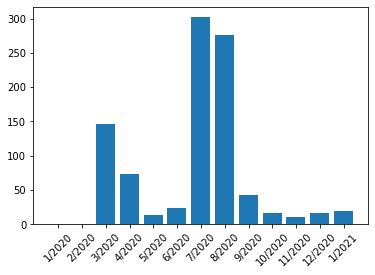

In [37]:
plot_graphs_query_1(query1,'Australia')

In [38]:
#unpersisting query 1 result
df_query1.unpersist()
df_query1_persist.unpersist()

DataFrame[Province/State: string, Country/Region: string, Day: int, Month: int, Year: int, Cases: int]

# Query 2

In [39]:
df_query2 =  df_preprocessed_persisted.select("Continent","Province/State",
                                              "Country/Region","Cases","Days Elapsed",
                                              "Date","Day","Week","Year","Longitude",
                                              "Latitude")\
                                      .sort("Continent","Country/Region",
                                            "Province/State",col("Date").asc())

In [40]:
"""df_query2_persist = df_query2.persist()"""

'df_query2_persist = df_query2.persist()'

In [41]:
"""df_query2.show()"""

'df_query2.show()'

### Compute the slope of the trendline

In [42]:
Regression = LinearRegression()

def linear_regression(x,y):
    """
    Returns the slope of the linear regression given x (independent variable) 
    and y (dependant variable).
    
    Parameters:
    x (column) : column Days Elapsed 
    y (column) : column Cases
    
    Returns:
    slope (float) : slope of the linear regression computed using the LinearRegression()
                    function of scikit-learn.
       
    """
    x1 = np.array(x).reshape(-1,1)
    y1 = np.array(y).reshape(-1,1)
    regressor = Regression.fit(x1,y1)
    a = regressor.coef_[-1,-1]
    slope = float(a)
    return slope

udf_linear_regression = F.udf(linear_regression,FloatType())

In [43]:
#introducing a dummy column to traverse the whole dataset and rank based on slope
#irrespective of any value
#Calculating regression curve slope for each state or country

window_query2_1 = Window.partitionBy("Province/State","Country/Region")
df_query2_reg = df_query2.withColumn("Cases_array",collect_list("Cases").over(window_query2_1))\
                         .withColumn("Days_Elapsed" , 
                                    collect_list("Days Elapsed").over(window_query2_1))\
                         .withColumn('Slope', 
                                     udf_linear_regression("Days_Elapsed","Cases_array"))\
                         .withColumn("Dummy", lit("1"))\
                         .drop("Cases_array","Days_Elapsed")\
                         .sort(col("Slope").desc())

In [44]:
df_query2_reg_persist = df_query2_reg.persist(StorageLevel.MEMORY_AND_DISK)

### Top 100 most affected states

In [45]:
"""df_query2_reg_persist = df_query2_reg.persist()"""

'df_query2_reg_persist = df_query2_reg.persist()'

In [46]:
# Selecting top 100 affected countries based on the coefficient

window_query2_2 =  Window.partitionBy("Dummy").orderBy(col("Slope").desc())
df_query2_top_100 = df_query2_reg_persist.select('*', 
                                            dense_rank().over(window_query2_2).alias('Rank'))\
                                         .filter(col('Rank') <= 100)\
                                         .drop("Dummy")\
                                         .sort(col("Rank").asc())

In [47]:
df_query2_top_100_persist = df_query2_top_100.persist(StorageLevel.MEMORY_AND_DISK)

In [48]:
df_top_100_states = df_query2_top_100_persist.select(["Province/State",
                                                      "Country/Region","Rank"])\
                                             .dropDuplicates()

In [49]:
#Calculating the weekly statistics for each countinent

query2_result = df_query2_top_100_persist.groupBy("Continent","Week","Year","Day") \
                                         .agg(sum("Cases").alias("Daily_Sum_Continent"))\
                                         .groupBy("Continent","Week","Year")\
                                         .agg(round(avg("Daily_Sum_Continent")
                                                    ,2).alias("Weekly_mean"),\
                                              round(stddev("Daily_Sum_Continent"),
                                                    2).alias("Weekly_Stddev"),\
                                              min("Daily_Sum_Continent").alias("Weekly_min"),\
                                              max("Daily_Sum_Continent").alias("Weekly_max"),\
                                              sum("Daily_Sum_Continent").alias("Weekly_Sum"))\
                                         .sort(asc("Continent"),asc("Year"),asc("Week"))

In [50]:
query2_result = query2_result.persist(StorageLevel.MEMORY_AND_DISK)

In [51]:
query2_result.show(100)

+---------+----+----+-----------+-------------+----------+----------+----------+
|Continent|Week|Year|Weekly_mean|Weekly_Stddev|Weekly_min|Weekly_max|Weekly_Sum|
+---------+----+----+-----------+-------------+----------+----------+----------+
|   Africa|   4|2020|        0.0|          0.0|         0|         0|         0|
|   Africa|   5|2020|        0.0|          0.0|         0|         0|         0|
|   Africa|   6|2020|        0.0|          0.0|         0|         0|         0|
|   Africa|   7|2020|       0.14|         0.38|         0|         1|         1|
|   Africa|   8|2020|        0.0|          0.0|         0|         0|         0|
|   Africa|   9|2020|       0.43|         0.53|         0|         1|         3|
|   Africa|  10|2020|      10.29|        13.88|         0|        39|        72|
|   Africa|  11|2020|      26.71|        21.65|         8|        68|       187|
|   Africa|  12|2020|     112.71|        42.23|        64|       181|       789|
|   Africa|  13|2020|     33

In [52]:
#saving the result in csv file
"""query2_result.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").mode('overwrite')\
   .save("query2")"""

'query2_result.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").mode(\'overwrite\')   .save("query2")'

In [53]:
end = time.time()
print(end - start)

485.98943042755127


## Plotting the outputs

In [54]:
#LatLong polygon used before to act as bounding box to identify the continents 
cord_euorope_lon = [-10,77.5,48.8,30,28.81,29,27.31,26.75,26.36,
                    25.19,27.91,27.5,10,-10,-13,-30,-37,-10] 
cord_euorope_lat = [90,90,42.5,42.5,40.79,41,40.55,40.40,40.05,
                    39.17,35.46,33,38,35.42,28.25,15,57.5,78.13]

cord_asia1_lon = [77.5,48.8,30,28.81,29,27.31,26.75,26.36,25.91,
                  35.46,27.5,34.58,34.92,34.46,44.3,52,75,
                  110,110,110,130,127,140,166,180,180]
cord_asia1_lat = [90,42.5,42.5,40.79,41,40.55,40.4,40.05,39.17,27.91,
                  33,31.74,29.54,27.78,11.3,12.5,-60,
                  -60,-31.88,-11.88,-8,0,33.13,51,60,90]
  
cord_asia2_lon = [-180,-168.75,-168.75,-180]
cord_asia2_lat = [90,90,60,60]

cord_Oceania_lon =[110,130,127.5,150,180,180,140,110]
cord_Oceania_lat = [-11.88,-8,0,5,0,-60,-60,-31.88]
  
    
cord_america_lat = [90,90,78.3,57.5,15,-60, -60,1.25,51,60,60,60]
cord_america_lon = [-168.75,-10,-10,-37.5,-30,-30,
                    -105,-105,-180,-180,-168.75,-168.75]   
   
cord_africa_lon = [-30,-13, -10, 10, 27.5, 34.58, 34.92, 34.46, 44.3, 52, 75, -30]
cord_africa_lat = [15,28.5, 35.42, 38, 38.33, 31.74, 29.54, 27.78, 11.3, 12.5 ,-60, -60]

cord_antarctica_lon =  [-180,180,180,-180]
cord_antarctica_lat =  [-60,-60,-90,-90]

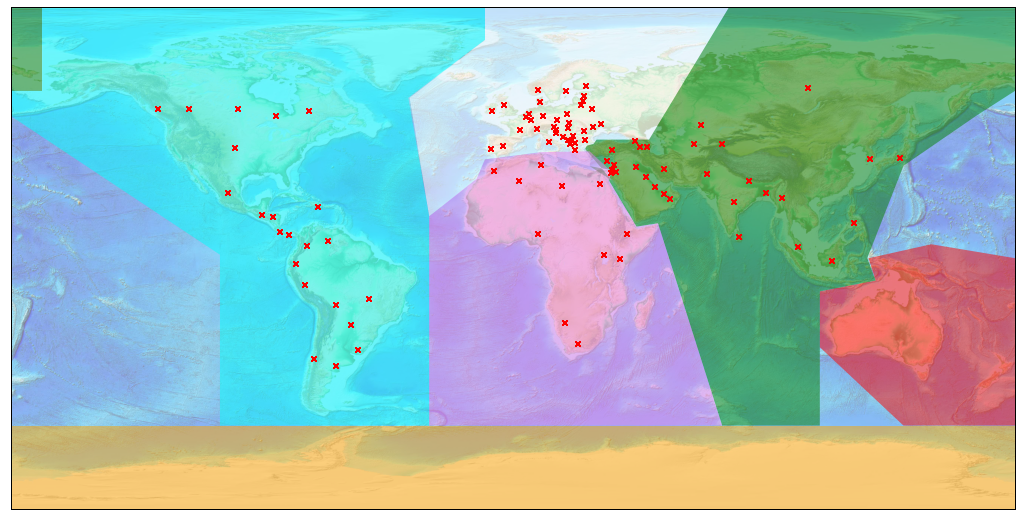

In [56]:
def draw_screen_poly(lats, lons, m, color):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = plg( list(xy), facecolor=color, alpha=0.5 )
    plt.gca().add_patch(poly)

    
    """"
    Plots a map  roughly devided by continents and showsthe 100 affected countires on the
    map.
    
    Parameters:
    cord_continent_lat - a list of preset latitude for each continent
    cord_continent_lon - a list of preset longtude for each continent
    m = Basemap configuration
    color = Color of the ploygon forming the bounding box
    The above mentioned lists are used to create ploygon for each continets these polygons were
    used as a bounding box while determining the contients.
    
    Return:
    This function does not return anything. It only plots the line graph.
    """
   
    
#def draw_screeen_point(query2_dataframe , m, ptcolor):
#    fig, ax = plt.subplots()
    
        

fig = plt.figure(figsize=(18, 12), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
m.etopo(scale=0.5, alpha=0.5)
m.drawmapboundary()

#draw_screeen_point(df_top_100_states_persist , m, "r")
draw_screen_poly( cord_Oceania_lat, cord_Oceania_lon, m,'red' )
draw_screen_poly( cord_euorope_lat, cord_euorope_lon, m,'white')
draw_screen_poly( cord_asia1_lat, cord_asia1_lon, m,'green')
draw_screen_poly( cord_asia2_lat, cord_asia2_lon, m,'green')
draw_screen_poly( cord_america_lat, cord_america_lon, m,'cyan')
draw_screen_poly( cord_antarctica_lat, cord_antarctica_lon, m,'orange')
draw_screen_poly( cord_africa_lat, cord_africa_lon, m,'violet')

subset = df_query2_top_100_persist
Latitude_L = [row["Latitude"] for row in subset.toLocalIterator()]
Longitude_L = [row["Longitude"] for row in subset.toLocalIterator()]
for i in range(len(Latitude_L)):
    lat = Latitude_L[i]
    long = Longitude_L[i]
    x,y = m(long,lat)
    plt.plot(x,y,'ok',marker = 'x',markersize=5,color="red")

    
    

plt.show()

In [57]:
def plot_graphs_query_2(query2_dataframe, continent):
    '''
    Plots the line graph of the aggergated weekly statistics
    for each week for the top 100 effected states.
    
    Parameters:
    query2_dataframe (dataframe): dataframe containing the weekly aggregated statistics of 
                                  new daily cases for each continent.
    continent (string): name of the chosen continent. 
    
    Return:
    This function does not return anything. It only plots the line graph.
    '''
    
    fig, ax = plt.subplots()
    subset = query2_dataframe.filter(col("Continent").isin([continent]))
    
    Agg_mean = [row["Weekly_mean"] for row in subset.toLocalIterator()]
    Agg_stddev = [row["Weekly_Stddev"] for row in subset.toLocalIterator()]
    Agg_min = [row["Weekly_min"] for row in subset.toLocalIterator()]
    Agg_max = [row["Weekly_max"] for row in subset.toLocalIterator()]
    Week = [row["Week"] for row in subset.toLocalIterator()]
    Week = [str(Week[i]) for i in range(len(Week))]
    indexes = list(range(len(Week)))
    bar_width = 0.01
    
    x1 =plt.plot( indexes, Agg_mean,label ='Weekly Mean' ,  color='skyblue', linewidth=3 )
    x2 = plt.plot( indexes, Agg_stddev, color='orange', linewidth=3 , label ='Weekly Std_Dev')
    x3 = plt.plot( indexes, Agg_min, color='green', linewidth=3 , label ='Weekly Min')
    x4 = plt.plot( indexes, Agg_max,label ='Weekly Max' , color='red', linewidth=3)
      
    plt.xlabel(f"Continent : {continent} \n Continentwise weekly statistics")
    plt.ylabel("Cases")
    plt.legend()  

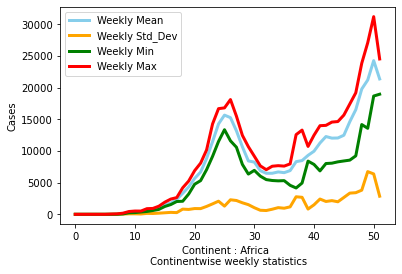

In [58]:
plot_graphs_query_2(query2_result,'Africa')

In [59]:
#unpersisting query 2 result
query2_result.unpersist()
df_query2_reg.unpersist()

DataFrame[Continent: string, Province/State: string, Country/Region: string, Cases: int, Days Elapsed: int, Date: date, Day: int, Week: int, Year: int, Longitude: double, Latitude: double, Slope: float, Dummy: string]

# Query 3 

In [60]:
# We keep the coordinates in order to plot the states in a map later on.

df_query3 = df_preprocessed_persisted.select("Province/State","Country/Region",
                                             "Latitude","Longitude",
                                             "Day","Month","Year",
                                             "Days Elapsed","Cases")

### Compute the slope of the trendline

In [61]:
window_query3_1 = Window.partitionBy("Province/State","Country/Region","Month","Year")
df_query3_reg = df_query3.withColumn("Cases_array",
                                     collect_list("Cases").over(window_query3_1))\
                         .withColumn("Days_Elapsed", 
                                     collect_list("Days Elapsed").over(window_query3_1))\
                         .withColumn('Slope',
                                     udf_linear_regression("Days_Elapsed","Cases_array"))\
                         .drop("Cases_array","Days_Elapsed")\
                         .sort(col("Slope").desc())

In [62]:
df_query3_reg_persist = df_query3_reg.persist()

### Top 50 most affected states on a monthly basis

In [63]:
# Selecting top 50 affected countries based on the coefficient for each month
window_query3_2 =  Window.partitionBy("Year","Month").orderBy(col("Slope").desc())
window_query3_3 =  Window.partitionBy("Year","Month").orderBy(col("Dense_rank").asc())

df_query3_top_50 = df_query3_reg_persist.select('*', 
                                    dense_rank().over(window_query3_2).alias('Dense_rank'))\
                                        .dropDuplicates(["Province/State",
                                                         "Country/Region","Year",
                                                         "Month","Dense_rank"])\
                                        .withColumn('Rank',rank().over(window_query3_3))\
                                        .drop("Dense_rank")\
                                        .filter(col('Rank') <= 50)\
                                        .sort("Year","Month",col("Rank").asc())

In [64]:
df_top_50_states = df_query3_top_50.select(["Province/State",
                                            "Country/Region","Year",
                                            "Month","Rank"])

In [65]:
df_top_50_states_persisted = df_top_50_states.persist()

In [66]:
query3 = df_query3_top_50.select("Province/State","Country/Region",
                                 "Latitude","Longitude",
                                 "Month","Year","Slope")

In [67]:
"""query3_persist = query3.persist()"""

'query3_persist = query3.persist()'

In [68]:
"""
#saving the result in csv file
query3.repartition(1).write\
                            .format("com.databricks.spark.csv")\
                            .option("header", "true")\
                            .mode('overwrite')\
                            .save("query3")"""

'\n#saving the result in csv file\nquery3.repartition(1).write                            .format("com.databricks.spark.csv")                            .option("header", "true")                            .mode(\'overwrite\')                            .save("query3")'

## Clustering

In [69]:
def k_means_nb_features(column_features,nb_cluster):
    """
    Return the desired dataframe after applying the K-means algorithm, with an additional
    prediction column which gives for each state, the cluster to which they belong.
    
    Parameters:
    column_features (List) : List of the features considered by the algorithm.
    nb_cluster (int) : Number of clusters set.
    
    Returns:
    query3_cluster (dataframe) : dataframe which gives for each state, the cluster to which  
    they belong.
    
    """
    
    """query3_file = query3_persist"""

    query3_file = spark.read.options(header='True', inferSchema='True', delimiter=',') \
                        .csv("query3.csv")
    
    columns = column_features
    
    #Encoding the categorical columns if there are 
    for i in range(len(columns)):
        if columns[i] == 'Province/State' or columns[i]=='Country/Region':
            stringIndexer = StringIndexer(inputCol=columns[i], 
                                         outputCol = columns[i]+"Index")\
                                        .setHandleInvalid("skip")
            query3_file = stringIndexer.fit(query3_file).transform(query3_file)
            encoder = OneHotEncoder(inputCol=columns[i]+"Index",
                                        outputCol=columns[i]+"_ohe")
            query3_file = encoder.fit(query3_file).transform(query3_file)
    
            columns[i] = columns[i]+'_ohe'

    vecAssembler = VectorAssembler(inputCols=columns, outputCol="features")
    df_kmeans = vecAssembler.transform(query3_file)
    
    #Applying the k-means algorithm

    Country_L = [row["Country/Region"] for row in df_kmeans.toLocalIterator()]
    State_L = [row["Province/State"] for row in df_kmeans.toLocalIterator()]
    Slope_L = [row["Slope"] for row in df_kmeans.toLocalIterator()]
    Year_L = [row["Year"] for row in df_kmeans.toLocalIterator()]
    Month_L = [row["Month"] for row in df_kmeans.toLocalIterator()]
    Cluster_L = [0 for row in df_kmeans.toLocalIterator()]
    Latitude_L = [row["Latitude"] for row in df_kmeans.toLocalIterator()]
    Longitude_L = [row["Longitude"] for row in df_kmeans.toLocalIterator()]

    i=0
    j=i
    while i<df_kmeans.count()-1 :
        while i<df_kmeans.count()-1 and Month_L[i]==Month_L[i+1] and Year_L[i] == Year_L[i+1] :
            i=i+1
        df_kmeans_subset = df_kmeans.filter(col('Month')==Month_L[i])\
                                        .filter(col('Year')==Year_L[i])
        k=nb_cluster
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_kmeans_subset)
        centers = model.clusterCenters()
        predictions = model.transform(df_kmeans_subset)
        Prediction_L = [row["prediction"] for row in predictions.toLocalIterator()]
        Cluster_L[j:i+1] = Prediction_L
        j=i
        i=i+1
    query3_cluster = spark.createDataFrame(zip(State_L,Country_L,
                                Latitude_L,Longitude_L,
                                Month_L,Year_L,
                                 Slope_L,Cluster_L), 
                             schema=["Province/State",
                                     "Country/Region",
                                     "Latitude","Longitude",
                                     'Month',"Year",
                                     "Slope","Cluster"])
    return query3_cluster

In [70]:
start = time.time()

In [71]:
query3_cluster_1feat = k_means_nb_features(['Slope'],4)

In [72]:
end = time.time()
print(end - start)

37.021358013153076


In [73]:
end2 = time.time()
print(end2 - start2)

994.1683690547943


In [74]:
"""query3_cluster_3feat = k_means_nb_features(['Slope','Province/State','Country/Region'],4)"""

"query3_cluster_3feat = k_means_nb_features(['Slope','Province/State','Country/Region'],4)"

In [75]:
def plot_points_in_map(dataframe_cluster,Month,Year):
    """
    Plots a map via the Basemap library displaying each state of top 50 
    depending on the cluster to which the state belongs.
    
    Parameters:
    dataframe_cluster (dataframe) : dataframe containing the State, the Country 
                                    to which it belongs, its latitude and longitude 
                                    and the cluster to which it belongs.
    Month (int) : number of the month chosen
    Year (int) : number of the year chosen
    
    Returns:
    It does not return anything. It plots a map.
    """
    fig = plt.figure(figsize=(18, 12), edgecolor='w')
    m = Basemap(projection='cyl', resolution=None,
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.etopo(scale=0.5, alpha=0.5)
    subset = dataframe_cluster.filter(col('Month').isin([Month]))\
              .filter(col('Year').isin([Year]))
    Country_L = [row["Country/Region"] for row in subset.toLocalIterator()]
    State_L = [row["Province/State"] for row in subset.toLocalIterator()]
    Cluster_L = [row["Cluster"] for row in subset.toLocalIterator()]
    Latitude_L = [row["Latitude"] for row in subset.toLocalIterator()]
    Longitude_L = [row["Longitude"] for row in subset.toLocalIterator()]
    for i in range(len(Country_L)):
        lat = Latitude_L[i]
        long = Longitude_L[i]
        x,y = m(long,lat)
        if Cluster_L[i]==0:
            plt.plot(x,y,'ok',markersize=5,color='b')
        elif Cluster_L[i]==1:
            plt.plot(x,y,'ok',markersize=5,color='k')
        elif Cluster_L[i]==2:
            plt.plot(x,y,'ok',markersize=5,color='r')
        else:
            plt.plot(x,y,'ok',markersize=5,color='m')
        """
        if State_L[i] != 'null':
            plt.text(x, y, str(State_L[i]), fontsize=8)
        else:
            plt.text(x, y, str(Country_L[i]), fontsize=8)
            
        """

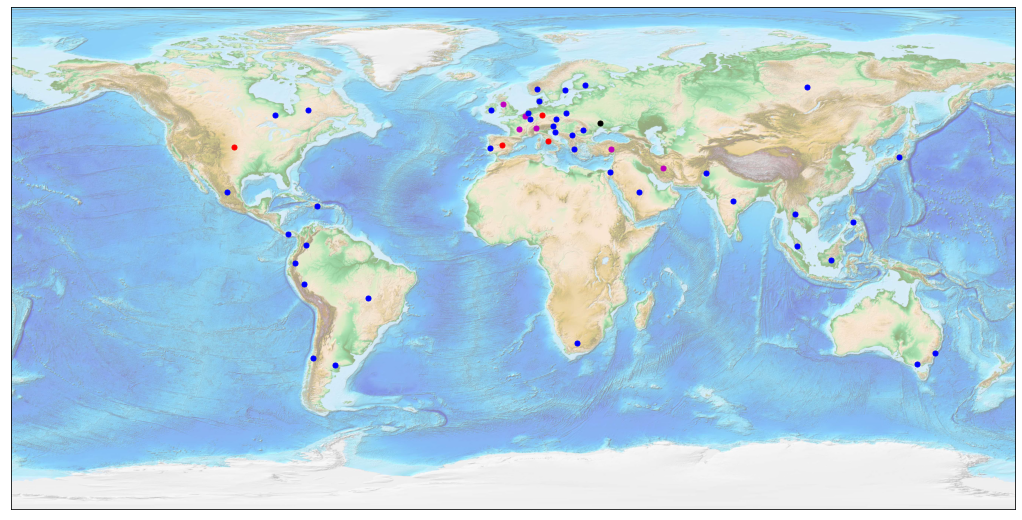

In [76]:
plot_points_in_map(query3_cluster_1feat,3,2020)

## Additional study of K-means

In [77]:
"""plot_points_in_map(query3_cluster_3feat,3,2020)"""

'plot_points_in_map(query3_cluster_3feat,3,2020)'

# V - End

In [78]:
df_preprocessed.unpersist()
df_preprocessed_persisted.unpersist()

DataFrame[Continent: string, Province/State: string, Country/Region: string, Latitude: double, Longitude: double, Date: date, Month: int, Day: int, Year: int, Week: int, Days Elapsed: int, Cases: int]

In [79]:
spark.stop()

In [80]:
sc.stop()